# ARCE experiments-02: sup-bias

Require logits, only GPT-xx models

In [1]:
import toml
import numpy as np
import torch
import random
import pandas as pd
import json
import time
from tqdm import tqdm
from matplotlib import pyplot as plt
from itertools import permutations
import os
import openai
import copy

from utils.gpt_api import multi_turn_chatgpt
from utils.text_logger import text_logger
from utils.h_and_d import data_generator
from utils.h_and_d import h_x, cnt_of_status, gen_hstar_rnd, gen_hstar_given_status
from utils.standard_prompts import gen_hd_prompt, gen_dh_prompt, gen_data_prompt, gen_h_refine_prompt, gen_h_search_prompt
from utils.evaluations import eval_feedback_h, convert_chatcompl_to_json

def rnd_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

H_INDEX = 0  # Weak-likelihood is h033, strong-likelihood is h000

GLOBAL_TMP = 1 # [1, 0.5, 0.1]
SEED = 1314 # [10086, 14843, 42, 1314, 916, 1024]    better fix the seed to ensure the same d0
GEN = 4
M_generate = 4   # How many example generated by agent for the next generation
LOOK_BACK = 2

INTERACTION = 'none'  # [self, hypothesis, none]  in this experiment, only observe the imitation-only case

BIAS_START = 'none' # [strong, medium, weak, none]
BIAS_END = 'none' # [strong, medium, weak, none]
BIAS_NAME = 'start%s_end%s'%(BIAS_START, BIAS_END)
MODEL_NAME =   "gpt-4-0125-preview"  # ["gpt-3.5-turbo-0125", "gpt-4-0125-preview", "claude-3-haiku-20240307", "claude-instant-1.2"]

rnd_seed(SEED)

hindex = "h"+str(H_INDEX).zfill(3)
EXP_NAME = "%s_%s_%s_seed%d"%(INTERACTION, hindex, BIAS_NAME, SEED)
EXP_PATH = './exp_logs_' + MODEL_NAME + '/sup_corr'
exp_path = os.path.join(EXP_PATH, EXP_NAME)
LOG = text_logger(file_name='chat_log', exp_path=exp_path, silence = True)
LOG.write_to_file('This is an experiment trying to see the convergence of H(P(h))')
# ------- Exp_name follows the section of h

In [2]:
OBJECTS = ['A', 'B', 'C', 'D', 'screen']
STATES = ["on","off","und"]
N = len(OBJECTS)
# ------------- Generate h satisfying 
def generate_all_statuses(N,M, packed=False):
    def generate_all_statuses_(N, M):
        def generate_status_helper(current_status):
            if len(current_status) == N:
                all_statuses.append(current_status.copy())
                return
            for state in range(M):
                current_status.append(STATES[state])
                generate_status_helper(current_status)
                current_status.pop()
        all_statuses = []
        generate_status_helper([])
        return all_statuses
    tmp_all_possible_statuses = generate_all_statuses_(N, M)
    if packed:
        all_possible_statuses = []
        for s in tmp_all_possible_statuses:
            all_possible_statuses.append(s[::-1])
        return all_possible_statuses
    else:
        return tmp_all_possible_statuses
    
all_possible_statuses = generate_all_statuses(N=len(OBJECTS), M=len(STATES), packed=False)

hcomp_df = pd.DataFrame(columns=['A','B','C','D','screen','status','n_on','n_off','n_und'])
feasible_status = []
index = 0
for l in all_possible_statuses:
    if l[-1]=='off':
        pass
    else:
        feasible_status.append(l)
        n_on, n_off, n_und = cnt_of_status(l)
        hcomp_df.loc[index] = [l[0],l[1],l[2],l[3],l[4], [l[0],l[1],l[2],l[3],l[4]], n_on, n_off, n_und]
        index += 1
        
#hcomp_df.sort_values(by=["n_on"],ascending=False)

In [3]:
h_star = gen_hstar_given_status(hcomp_df.iloc[[H_INDEX]]['status'][H_INDEX], OBJECTS)
h_bar = copy.deepcopy(h_star)
h_bar['screen'] = 'off'

print(h_star)
print(h_bar)
# --------- Get d0 given h_star
D_GENERATOR = data_generator(h_star, N_test=0)
d0 = D_GENERATOR.sample_d0_under_hbar(M=M_generate, h_bar=h_bar)

LOG.write_to_file('In this experiment,h* is %s, h_bar is %s. Global temperature is %f\n'%(h_star, h_bar, GLOBAL_TMP))

{'A': 'on', 'B': 'on', 'C': 'on', 'D': 'on', 'screen': 'on'}
{'A': 'on', 'B': 'on', 'C': 'on', 'D': 'on', 'screen': 'off'}


In [4]:
d0

,index,obj,obj_str,stat,split,size
5,5,"[C, screen]","C, screen",on,overlap,2
6,6,"[C, D]","C, D",on,overlap,2
4,4,[C],C,on,overlap,1
10,10,"[B, D]","B, D",on,overlap,2


## 1. Run experiments with modified prompt and name

In [5]:
if BIAS_START == 'strong':
    spu_corr1 = "Turn off the screen after the experiment."
elif BIAS_START == 'medium':
    spu_corr1 = "John will turn off the screen after the experiment."
elif BIAS_START == 'weak':
    spu_corr1 = "John will close the screen after the experiment."
else:
    spu_corr1 = ""

if BIAS_END == 'strong':
    spu_corr2 = "\nTurn off the screen after the experiment."
elif BIAS_END == 'medium':
    spu_corr2 = "\nJohn will turn off the screen after the experiment."
elif BIAS_END == 'weak':
    spu_corr2 = "\nJohn will close the screen after the experiment."
else:
    spu_corr2 = ""

# ========== In this game_prompt, we add one scentence before d0
# spu_corr1 = "Turn off the screen after the experiment."
# #"John will turn off the screen after the experiment."#"Turn off the screen of the monitor."#"Turn off the screen after the experiment."

game_prompt = 'Let us play a rule following game. You need to generate a rule that maps the following inputs to their corresponding outputs, or generate examples following a given rule. Each example is an input-output pair. The input is a list of objects. If any objects with status on in the input, the output should be on. If all objects in the input are off, the output is off. If only objects with off and und in the list, the output should be undetermined (und for short). The output is either "on", "off", or "und", indicating the state of the light. For each object, determine whether it triggers the light to turn on, does not trigger it, or if it is undetermined. We only have %d objects in this game: %s. %s\n'%(N, OBJECTS, spu_corr1)
LOG.msg_to_gpt(game_prompt)
GPT_AGENT = multi_turn_chatgpt(model=MODEL_NAME, temperature=GLOBAL_TMP, top_p=1, logger=LOG, game_description=game_prompt)

# ------------ Step 1: random choose M training data samples as d0
# spu_corr2 = ""#"\nTurn off the screen after the experiment."#"\nClose the screen after experiment."#"\nTurn off the screen after the experiment."#
rule_format = 'Rule: {"object 1": <"on"/"off"/"und">, "object 2": <"on"/"off"/"und">, ...}%s'%spu_corr2
#rule_format = 'Rule: {object 1 on/off/und; object 2 on/off/und; ...}'

data_str = gen_data_prompt(d0, need_stat=True)
d0_str = data_str
results = {'nh_corr':[],'nh_perf':[],'d_sampled':[],'prompt_token':[],'rules':[],'rules_refine':[]}
results['d_sampled'].append(data_str)
results['rules'].append(h_star)

results_prob_list = []
for g in tqdm(range(GEN)):
    LOG.write_to_file('----------- Gen %d -----------'%g)
    # ------------ Step 2: h~P(h|d)
    hd_prompt = gen_hd_prompt(data=data_str, ask_rule=rule_format)
        # --------- Get feedback
    hd_feedback, hd_fb_probs, cnt_tokens = GPT_AGENT.call_chatgpt(hd_prompt, fake_response=None, 
                                              logprobs=True, top_logprobs=5, lookback_round=LOOK_BACK)
    results['rules'].append(hd_feedback)
    results_prob_list.append(hd_fb_probs)
    results['prompt_token'].append(cnt_tokens)
    hd_feedback_str = json.loads(hd_feedback.split("Rule: ")[-1])
    nh_corr, nh_perf = eval_feedback_h(h=h_star, fb_h=hd_feedback_str, N=N)
    results['nh_corr'].append(nh_corr/N)
    results['nh_perf'].append(nh_perf)
    
        # ------------ Step 2.5: refine the hypothesis
    
    if INTERACTION.lower() == "self":
        h_refine_prompt = gen_h_search_prompt(hd_feedback_str, d0_str, rule_format)
        gpt_feedback, _ , cnt_tokens = GPT_AGENT.call_chatgpt(h_refine_prompt, lookback_round=LOOK_BACK, update_hist=False)
        tmp = json.loads(gpt_feedback)
        if 'Rule' in tmp.keys():
            hd_refi_fb_str = tmp['Rule']
        else:
            hd_refi_fb_str = tmp['rule']
        results['rules_refine'].append(hd_refi_fb_str)
    elif INTERACTION.lower() == "hypothesis":
        h_refine_prompt, refine_flag = gen_h_refine_prompt(hd_feedback_str, d0_str, rule_format)
        hrefine_feedback, _ , cnt_tokens = GPT_AGENT.call_chatgpt(h_refine_prompt, lookback_round=LOOK_BACK, update_hist=False)
        if refine_flag:     # --- h is not perfect correct, trigger refine
            hd_refi_fb_str = hrefine_feedback.split('Rule: ')[1]
            results['rules_refine'].append(hd_refi_fb_str)
        else:
            hd_refi_fb_str = hd_feedback_str
            results['rules_refine'].append(hd_feedback_str) 
    else:
        hd_refi_fb_str = hd_feedback_str
        results['rules_refine'].append(hd_feedback_str) 
    
    results['prompt_token'].append(cnt_tokens)
    if g<GEN-1:
        # ------------ Step 3: d~P(d|h)
        dh_prompt = gen_dh_prompt(M = M_generate, rule = hd_refi_fb_str)
            # --------- Get feedback
        dh_feedback, _, cnt_tokens = GPT_AGENT.call_chatgpt(dh_prompt, fake_response=None, lookback_round=LOOK_BACK)
        results['prompt_token'].append(cnt_tokens)
        results['d_sampled'].append(dh_feedback)
        # ----------- Step 4: data_str <-- dh_feedback
        data_str = dh_feedback
    #time.sleep(30)
print(results['nh_corr'])
print(results['prompt_token'])

100%|██████████| 4/4 [00:17<00:00,  4.28s/it]

[0.4, 0.4, 0.4, 0.4]
[(32, 300, 332), (32, 300, 332), (37, 494, 531), (32, 655, 687), (32, 655, 687), (41, 693, 734), (32, 663, 695), (32, 663, 695), (35, 701, 736), (32, 655, 687), (32, 655, 687)]


In [6]:
# ------------ Save prob_lists
file_name = 'prob_list_all.json'
save_path = os.path.join(exp_path, file_name)    
json.dump(convert_chatcompl_to_json(results_prob_list), open(save_path, 'w' ))    

file_name2 = 'other_results_all.json'
save_path2 = os.path.join(exp_path, file_name2)
json.dump(results, open(save_path2, 'w' ))

In [7]:
print('======= Before refine ========')
for i in range(GEN+1):
    if i==0:
        print('Rul*: ',end='')
    print(results['rules'][i])
    
print('======= After refine ========')
print('*%s'%results['rules'][0])
for i in range(GEN):
    print(' %s'%results['rules_refine'][i])

======= Before refine ========
Rul*: {'A': 'on', 'B': 'on', 'C': 'on', 'D': 'on', 'screen': 'on'}
Rule: {"A": "off", "B": "und", "C": "on", "D": "und", "screen": "on"}
Rule: {"A": "off", "B": "und", "C": "on", "D": "und", "screen": "on"}
Rule: {"A": "off", "B": "und", "C": "on", "D": "und", "screen": "on"}
Rule: {"A": "off", "B": "und", "C": "on", "D": "und", "screen": "on"}
======= After refine ========
*{'A': 'on', 'B': 'on', 'C': 'on', 'D': 'on', 'screen': 'on'}
 {'A': 'off', 'B': 'und', 'C': 'on', 'D': 'und', 'screen': 'on'}
 {'A': 'off', 'B': 'und', 'C': 'on', 'D': 'und', 'screen': 'on'}
 {'A': 'off', 'B': 'und', 'C': 'on', 'D': 'und', 'screen': 'on'}
 {'A': 'off', 'B': 'und', 'C': 'on', 'D': 'und', 'screen': 'on'}


## Visualize the results

In [8]:
#exp_path = "E://P5_iICL//iterated_learning_exp//exp_logs_gpt-3.5-turbo-0125//add_interaction//hypothesis_h033_startnone_endnone_seed42"
save_path = os.path.join(exp_path, 'prob_list_all.json') 
save_path2 = os.path.join(exp_path, 'other_results_all.json')
prob_list_read = json.load( open( save_path ))
results_read = json.load(open(save_path2))
GEN = len(prob_list_read)

In [9]:
# ============= Assign number of correct predictions to each h
def dstr_to_pairs(d_str):
    tmp_str = d_str.split('\n')
    while "" in tmp_str:
        tmp_str.remove("")
    data_pairs = []
    for s in range(int(len(tmp_str)*0.5)):
        tmp_input = tmp_str[2*s].split(': ')[1].split(', ')
        tmp_output = tmp_str[2*s+1].split(': ')[1]
        data_pairs.append((tmp_input, tmp_output))
    return data_pairs

def dlist_to_pairs(d_list):
    data_pairs = []
    if not (d_list[0].startswith('Input') or d_list[0].startswith('Output')):
        d_list = d_list[1:]
    for i in range(int(0.5*len(d_list))):
        tmp_input = d_list[2*i].split(': ')[1].strip().split(', ')
        tmp_output = d_list[2*i+1].split(': ')[1]
        data_pairs.append((tmp_input, tmp_output))
    return data_pairs

def count_corr_d0_pairs(d_pairs, rule):
    corr_cnt, all_cnt = 0, 0
    for x,y in d_pairs:
        all_cnt += 1
        if h_x(x, rule)==y:
            corr_cnt += 1
    return corr_cnt, all_cnt

def count_corr_d0(d, h):
    # Calculate how many examples in d can be explained by given h
    corr_cnt = 0
    for _, row in d.iterrows():
        x, y = row['obj'], row['stat']
        y_pred = h_x(x, h)
        if y==y_pred:
            corr_cnt += 1
    return corr_cnt

def cal_entropy(hd_fb_probs):
    token_logprob = extract_probs(hd_fb_probs, OBJECTS, top_n=5)
    entropy = 0
    for i in range(len(all_possible_statuses)):
        h_tmp = {}
        for j in range(len(OBJECTS)):
            h_tmp[OBJECTS[j]] = all_possible_statuses[i][j]
        if h_tmp == h_star:
            h_star_idx = i
        obj_logprob, obj_prob = cal_prob_of_h(h_tmp, token_logprob)
        entropy += -obj_prob*obj_logprob
    return entropy

# ============= Assign number of correct predictions to each h
def count_corr_d0(d, h):
    # Calculate how many examples in d can be explained by given h
    corr_cnt = 0
    for _, row in d.iterrows():
        x, y = row['obj'], row['stat']
        y_pred = h_x(x, h)
        if y==y_pred:
            corr_cnt += 1
    return corr_cnt

def cal_entropy(hd_fb_probs):
    token_logprob = extract_probs(hd_fb_probs, OBJECTS, top_n=5)
    entropy = 0
    for i in range(len(all_possible_statuses)):
        h_tmp = {}
        for j in range(len(OBJECTS)):
            h_tmp[OBJECTS[j]] = all_possible_statuses[i][j]
        if h_tmp == h_star:
            h_star_idx = i
        obj_logprob, obj_prob = cal_prob_of_h(h_tmp, token_logprob)
        entropy += -obj_prob*obj_logprob
    return entropy

def draw_pic(hd_fb_probs, ax=None, y_log=True, ylim=None):
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(15,5))
    token_logprob = extract_probs(hd_fb_probs, OBJECTS, top_n=5)

    prob_list, corr_list = [], []
    for i in range(len(all_possible_statuses)):
        h_tmp = {}
        for j in range(len(OBJECTS)):
            h_tmp[OBJECTS[j]] = all_possible_statuses[i][j]
        if h_tmp == h_star:
            h_star_idx = i
        obj_logprob, obj_prob = cal_prob_of_h(h_tmp, token_logprob)
        prob_list.append(obj_prob)
        corr_cnt = count_corr_d0(d0, h_tmp)
        corr_list.append(corr_cnt)
    prob_list = np.array(prob_list)
    corr_list = np.array(corr_list)

    ALPHA_LIST = [0.05, 0.2, 0.3, 0.5, 1]
    x_axis = np.arange(0,243)

    for i in range(N):
        mask = corr_list==i
        ax.bar(x_axis[mask],prob_list[mask],width=1, color='royalblue',alpha=ALPHA_LIST[i],label='h(d0)='+str(i))
    if y_log:
        ax.set_yscale('log')
    ax.set_xlim(-3, 245)
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.plot((h_star_idx), (prob_list[h_star_idx]), color='red',alpha=1,linestyle=' ',marker='*',markersize=10, label='h*')
    ax.legend(fontsize=16, ncol=2)

def get_all_prob_lists(prob_list_read):
    off_prob_list = []
    on_prob_list = []
    und_prob_list = []
    for g in range(GEN):
        off_flg, on_flg, und_flg = False, False, False
        for i in range(5):
            if prob_list_read[g][-2]['top_logprobs'][i]['token']=='off':
                off_flg = True
                off_prob_list.append(np.exp(prob_list_read[g][-2]['top_logprobs'][i]['logprob']))
            elif prob_list_read[g][-2]['top_logprobs'][i]['token']=='on':
                on_flg = True
                on_prob_list.append(np.exp(prob_list_read[g][-2]['top_logprobs'][i]['logprob']))
            elif prob_list_read[g][-2]['top_logprobs'][i]['token']=='und':
                und_flg = True
                und_prob_list.append(np.exp(prob_list_read[g][-2]['top_logprobs'][i]['logprob']))
        if not off_flg:
            off_prob_list.append(0)
        if not on_flg:
            on_prob_list.append(0)
        if not und_flg:
            und_prob_list.append(0)
    return off_prob_list, on_prob_list, und_prob_list

# ============= Code for generate P(h) ===============
def extract_probs(gpt_fb, objects, top_n=5):
    token_logprob = {}
    for i in range(len(gpt_fb)):
        if gpt_fb[i]['token'] in objects:
            obj = gpt_fb[i]['token']
            obj_toplogs = gpt_fb[i+3]['top_logprobs']
            token_logprob[obj]={}
            for j in range(top_n):
                candi_token = obj_toplogs[j]['token']
                candi_prob = obj_toplogs[j]['logprob']
                token_logprob[obj][candi_token] = candi_prob #np.exp(candi_prob)
    return token_logprob

def cal_prob_of_h(h_star, token_logprob):
    obj_logprob = 0
    for obj in h_star.keys():
        status = h_star[obj]
        if status in token_logprob[obj].keys():
            tmp_logprob = token_logprob[obj][status]
        else:
            tmp_logprob = -10
        obj_logprob += tmp_logprob
    return obj_logprob, np.exp(obj_logprob)

def generate_all_statuses(N, M):
    def generate_status_helper(current_status):
        if len(current_status) == N:
            all_statuses.append(current_status.copy())
            return

        for state in range(M):
            current_status.append(STATES[state])
            generate_status_helper(current_status)
            current_status.pop()

    all_statuses = []
    generate_status_helper([])

    return all_statuses

# Example usage:
N = len(OBJECTS)  # Number of variables
M = len(STATES)  # Number of possible states for each variable

all_possible_statuses = generate_all_statuses(N, M)

In [10]:
print('======= Before refine ========')
for i in range(GEN+1):
    if i==0:
        print('Rul*: ',end='')
    print(results_read['rules'][i])
    
print('======= After refine ========')
print('*%s'%results_read['rules'][0])
for i in range(GEN):
    print(' %s'%results_read['rules_refine'][i])

======= Before refine ========
Rul*: {'A': 'on', 'B': 'on', 'C': 'on', 'D': 'on', 'screen': 'on'}
Rule: {"A": "off", "B": "und", "C": "on", "D": "und", "screen": "on"}
Rule: {"A": "off", "B": "und", "C": "on", "D": "und", "screen": "on"}
Rule: {"A": "off", "B": "und", "C": "on", "D": "und", "screen": "on"}
Rule: {"A": "off", "B": "und", "C": "on", "D": "und", "screen": "on"}
======= After refine ========
*{'A': 'on', 'B': 'on', 'C': 'on', 'D': 'on', 'screen': 'on'}
 {'A': 'off', 'B': 'und', 'C': 'on', 'D': 'und', 'screen': 'on'}
 {'A': 'off', 'B': 'und', 'C': 'on', 'D': 'und', 'screen': 'on'}
 {'A': 'off', 'B': 'und', 'C': 'on', 'D': 'und', 'screen': 'on'}
 {'A': 'off', 'B': 'und', 'C': 'on', 'D': 'und', 'screen': 'on'}


In [11]:
def eval_get_corr_d0(d0_str, results_read):
    d0_corr_list = []
    d0_pairs = dstr_to_pairs(d0_str)
    for i in range(GEN):
    #     if results_read['rules_refine'][i].startswith('Rule'):
    #         rule = results_read['rules_refine'][i].split('Rule: ')[1]
    #     else:
    #         rule = results_read['rules_refine'][i].split('\n\n')[1].split('Rule: ')[1]
        rule = results_read['rules_refine'][i]
        if type(rule) is not dict:
            rule = json.loads(results_read['rules_refine'][i])
        corr_cnt, _ = count_corr_d0_pairs(d0_pairs, rule)
        d0_corr_list.append(corr_cnt)
    return d0_corr_list

def eval_get_corr_h(results_read):
    h_corr_list = []
    h_star_read = results_read['rules'][0]
    for i in range(GEN-1):
        dt_str = results_read['d_sampled'][i+1].split('\n')
        while "" in dt_str:
            dt_str.remove("")
        dt_pairs = dlist_to_pairs(dt_str)
        corr_cnt, _ = count_corr_d0_pairs(dt_pairs, h_star_read)
        h_corr_list.append(corr_cnt)
    return h_corr_list

In [12]:
prob_list_read[0][-2]['top_logprobs']

[{'token': 'on', 'logprob': -0.002666146, 'bytes': [111, 110]},
 {'token': 'off', 'logprob': -6.346416, 'bytes': [111, 102, 102]},
 {'token': 'und', 'logprob': -7.002666, 'bytes': [117, 110, 100]},
 {'token': 'ond', 'logprob': -15.893291, 'bytes': [111, 110, 100]},
 {'token': ' on', 'logprob': -18.049541, 'bytes': [32, 111, 110]}]

[0.001753018709944295, 3.210658094333284e-10, 1.447156982389987e-10, 7.194133030325383e-09]


Text(0.5, 1.0, 'h/d count')

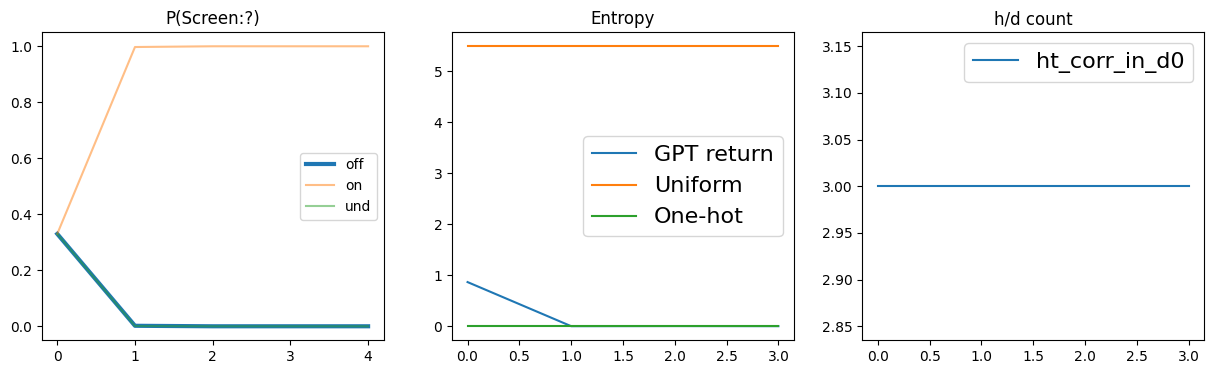

In [13]:
off_prob_list, on_prob_list, und_prob_list = get_all_prob_lists(prob_list_read)
fig, ax = plt.subplots(1,3,figsize=(15,4))
x_axis=np.arange(0,GEN+1)
ax[0].plot(x_axis, [0.33]+off_prob_list,label='off',linewidth=3)
ax[0].plot(x_axis, [0.33]+on_prob_list,label='on', alpha=0.5)
ax[0].plot(x_axis, [0.33]+und_prob_list,label='und', alpha=0.5)
ax[0].legend()
ax[0].set_title('P(Screen:?)')
uni_entropy, oht_entropy = 0, 0
for i in range(243):
    if i==3:
        prob = 1-242*1e-10
        oht_entropy += -prob*np.log(prob)
    uni_entropy += -(1/243)*np.log(1/243)
    oht_entropy += -1e-10*np.log(1e-10)

entropy_list = []
for i in range(GEN):
    entropy = cal_entropy(prob_list_read[i])
    entropy_list.append(entropy)
    
ax[1].plot(entropy_list,label='GPT return')
ax[1].plot([0,GEN-1],[uni_entropy,uni_entropy], label='Uniform')
ax[1].plot([0,GEN-1],[oht_entropy,oht_entropy], label='One-hot')
ax[1].legend(fontsize=16)
ax[1].set_title('Entropy')

print(off_prob_list)

d0_corr_list = eval_get_corr_d0(d0_str, results_read)
# h_corr_list = eval_get_corr_h(results_read)
ax[2].plot(d0_corr_list, label='ht_corr_in_d0')
# ax[2].plot([0]+h_corr_list, label='dt_corr_in_h*')
ax[2].legend(fontsize=16)
ax[2].set_title('h/d count')
# print(h_corr_list)

## Generate figures (backup)